# Customer Segmentation Using RFM Analysis

This notebook performs RFM (Recency, Frequency, Monetary) analysis on sales data to segment customers based on their purchase behavior. The goal is to identify valuable customer groups and tailor marketing strategies to improve retention and sales performance.


**Steps included:**  
- Data loading and cleaning  
- RFM metric calculation  
- Customer segmentation and scoring  
- Visualization of customer segments

***Import libraries***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

***Loading the Dataset***

In [3]:
file_path = '/content/OnlineRetail.xlsx'
data = pd.read_excel(file_path)

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


***Explore the dataset***

In [5]:
# Check basic info
data.info()

# Check for missing values
data.isnull().sum()

# Check basic statistics
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [6]:
# Convert InvoiceDate to datetime if not already
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Drop rows with missing CustomerID
data = data.dropna(subset=['CustomerID'])

# Create RFM features

Recency: Days since last purchase

Frequency: Number of invoices per customer

Monetary: Total spend per customer

In [10]:
# Set reference date for Recency (usually the day after the last purchase)
import datetime
reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate RFM metrics
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'UnitPrice': lambda x: (x * data.loc[x.index, 'Quantity']).sum() # Monetary
}).reset_index()

# Rename columns
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'UnitPrice': 'Monetary'}, inplace=True)

# Display RFM table
display(rfm.head())

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


# Assign RFM scores

Score each metric from 1 to 5 (1 = worst, 5 = best)

Use quantiles for scoring

In [11]:
# Assign RFM scores based on quantiles (1 to 5, 1 being the worst, 5 being the best)

# For Recency, lower is better, so we'll reverse the scoring
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# For Frequency and Monetary, higher is better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# Display RFM table with scores
display(rfm.head())

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,12346.0,326,2,0.00,1,2,1
1,12347.0,2,7,4310.00,5,4,5
2,12348.0,75,4,1797.24,2,3,4
3,12349.0,19,1,1757.55,4,1,4
4,12350.0,310,1,334.40,1,1,2


***Segment customers based on RFM***

In [12]:
# Combine RFM scores into a single string
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Display RFM table with the combined score
display(rfm.head())

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,2,0.00,1,2,1,121
1,12347.0,2,7,4310.00,5,4,5,545
2,12348.0,75,4,1797.24,2,3,4,234
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


In [17]:
# Define customer segments based on RFM_Score (example segmentation)
segment_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose Them',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfm['Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['Segment'] = rfm['RFM_Score'].replace(segment_map, regex=True)

# ***Visualize RFM segments***

***Bar chart of segment counts***

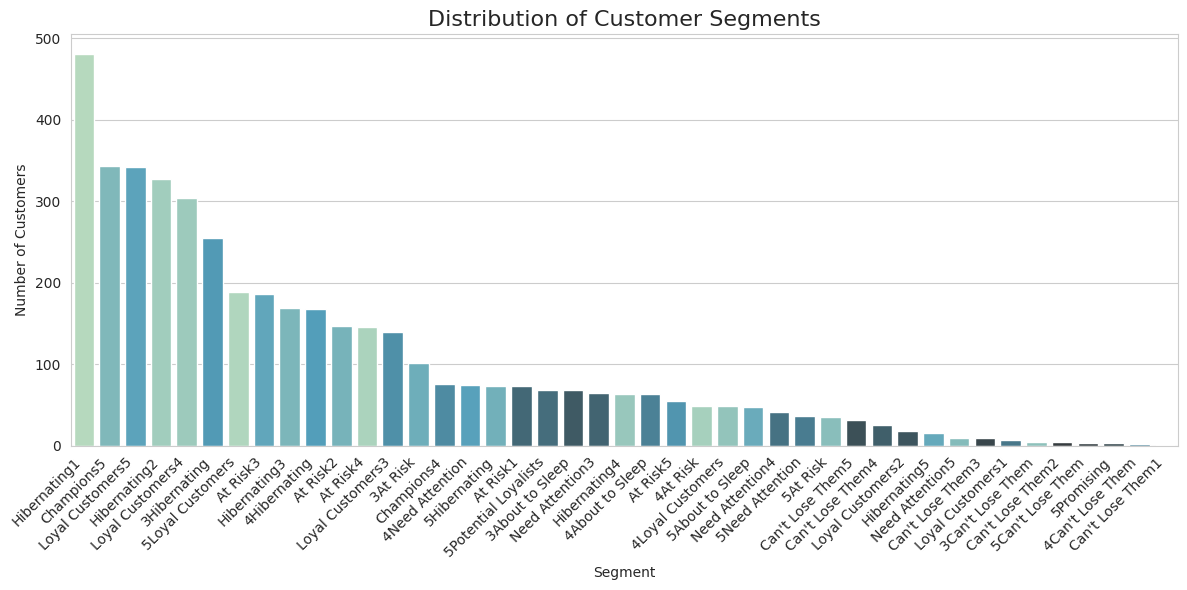

In [21]:
# Visualize segment counts
plt.figure(figsize=(12, 6))
sns.countplot(data=rfm, x='Segment', hue='Segment', palette='GnBu_d', order=rfm['Segment'].value_counts().index, legend=False)
plt.title("Distribution of Customer Segments", fontsize=16)
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

***Heatmap for average RFM values per segment***

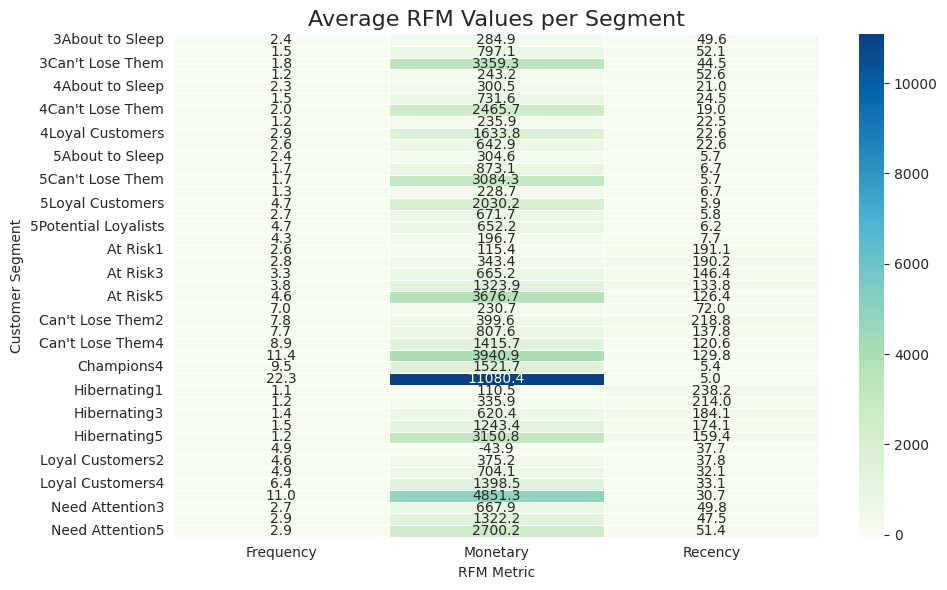

In [15]:
# Calculate average RFM values per segment
segment_rfm = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Melt the dataframe for heatmap
segment_rfm_melted = pd.melt(segment_rfm,
                             id_vars=['Segment'],
                             value_vars=['Recency', 'Frequency', 'Monetary'],
                             var_name='Metric',
                             value_name='AverageValue')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(segment_rfm_melted.pivot(index='Segment', columns='Metric', values='AverageValue'),
            annot=True, fmt=".1f", cmap="GnBu", linewidths=.5)
plt.title("Average RFM Values per Segment", fontsize=16)
plt.xlabel("RFM Metric")
plt.ylabel("Customer Segment")
plt.tight_layout()
plt.show()

***Scatter Plots***

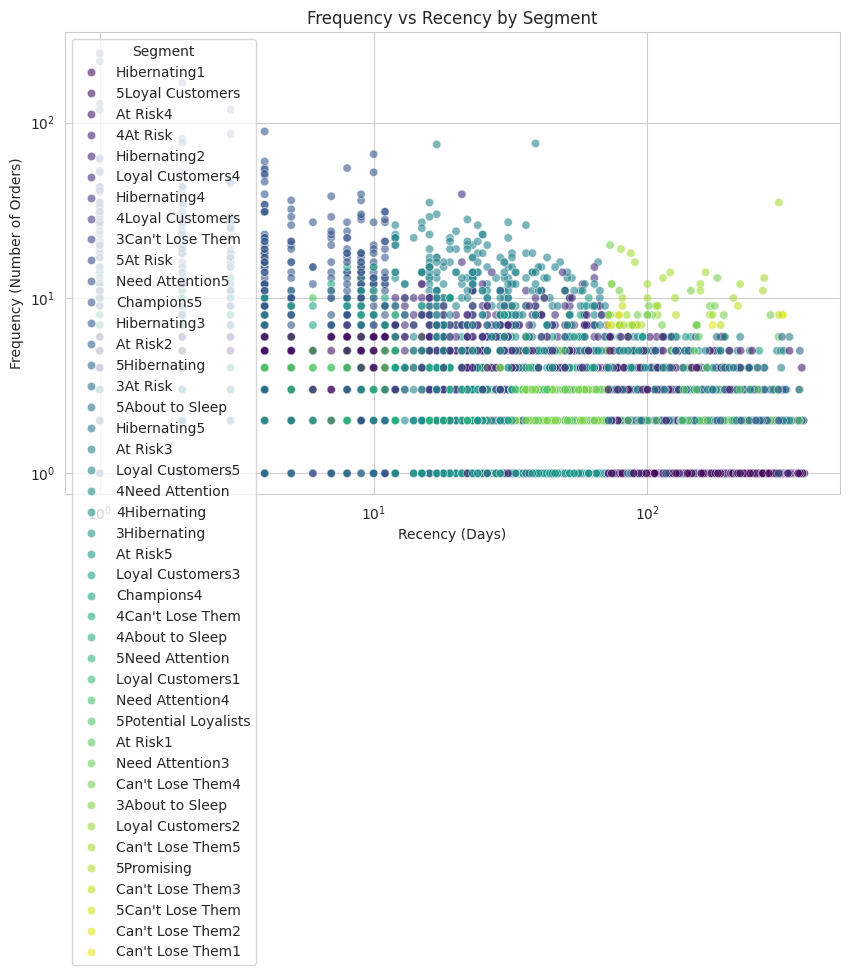

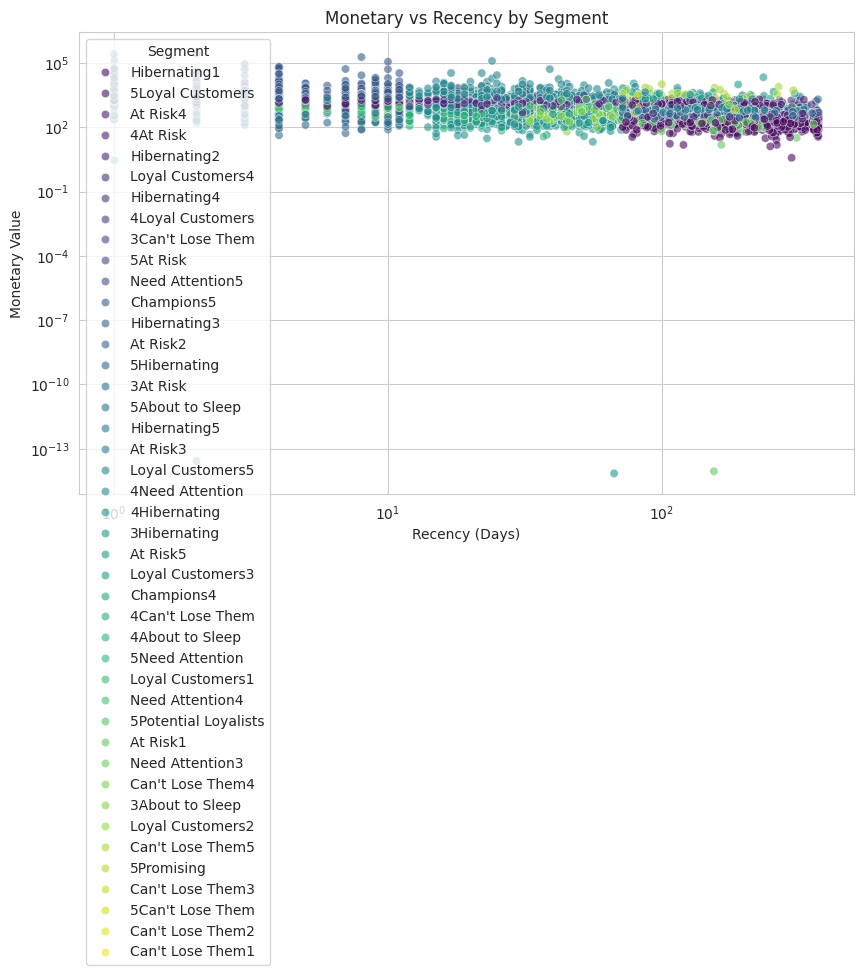

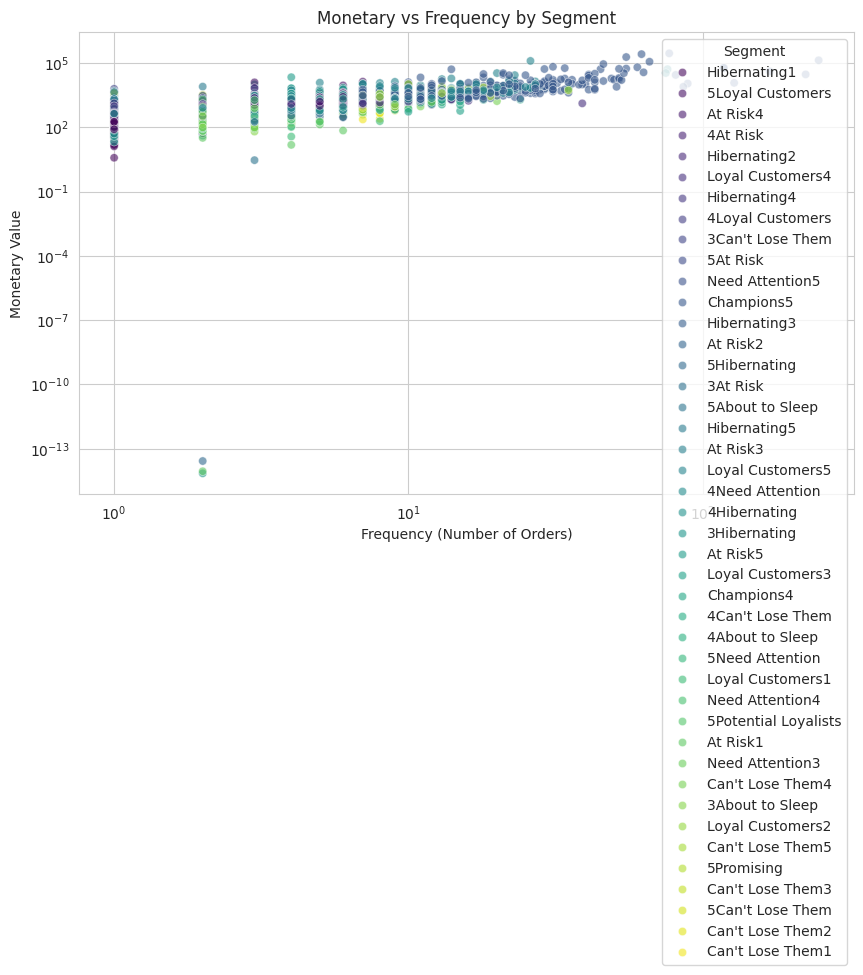

In [16]:
# Scatter plot of Frequency vs Recency
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Segment', palette='viridis', alpha=0.6)
plt.title('Frequency vs Recency by Segment')
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency (Number of Orders)')
plt.xscale('log') # Use log scale for better visualization if data is skewed
plt.yscale('log') # Use log scale for better visualization if data is skewed
plt.show()

# Scatter plot of Monetary vs Recency
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='viridis', alpha=0.6)
plt.title('Monetary vs Recency by Segment')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary Value')
plt.xscale('log') # Use log scale for better visualization if data is skewed
plt.yscale('log') # Use log scale for better visualization if data is skewed
plt.show()

# Scatter plot of Monetary vs Frequency
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segment', palette='viridis', alpha=0.6)
plt.title('Monetary vs Frequency by Segment')
plt.xlabel('Frequency (Number of Orders)')
plt.ylabel('Monetary Value')
plt.xscale('log') # Use log scale for better visualization if data is skewed
plt.yscale('log') # Use log scale for better visualization if data is skewed
plt.show()